In [37]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import itertools
import csv
pd.options.display.max_colwidth=500
from tqdm import tqdm
import os

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

def visualize_graph(graph, custom_pos=None, size=(16, 10)):
    # Set the color palette
    sns.set_palette('Set2', n_colors=4)
    color_map = {
        'Column': sns.color_palette()[0],
        'Row': sns.color_palette()[1],
        'Token': sns.color_palette()[2],
        'Data': sns.color_palette()[3],
        'document_similarity': sns.color_palette()[4],
        'word_similarity': sns.color_palette()[5],
        'unknown': 'gray'
    }

    fig, ax = plt.subplots(figsize=size)
    
    node_colors = [data.get('type', 'unknown') for _, data in graph.nodes(data=True)]
    node_colors = [color_map.get(node_type, 'gray') for node_type in node_colors]

    # Set node size based on the length of the labels
    node_data = [data for _, data in graph.nodes(data=True)]


    node_sizes = []

    for data in node_data:
        if('label' in data):
            node_sizes.append(1200 + len(data['label']))
        else:
            node_sizes.append(1500)
    
    
    # node_sizes = [1200 + len(data['label']) * 15 for _, data in graph.nodes(data=True)]

    nx.draw_networkx_nodes(graph, custom_pos, node_color=node_colors, node_size=node_sizes, edgecolors='k', linewidths=0.5)
    
    # Set font size and weight based on the node type
    for node, data in graph.nodes(data=True):
        font_size = 8 if data['type'] == 'Data' else 10
        font_weight = 'bold' if data['type'] != 'Data' else 'normal'
        nx.draw_networkx_labels(graph, {node: custom_pos[node]}, 
                                labels={node: data['label']}, font_size=font_size, 
                                font_weight=font_weight)
    
    nx.draw_networkx_edges(graph, custom_pos, edge_color='gray', alpha=0.5, width=1,
                           arrows=False, connectionstyle='arc3,rad=0.1')
    
    plt.axis('equal')
    plt.axis('off')
    plt.show()

In [39]:
import sys
sys.path.append('../')
from utils import *
from graphUtils import *

In [40]:
# Load movie reviews dataset
movie_reviews = pickle.load(open('../../data/imdb/imdb_reviews_1000film.df', 'rb'))[:100]

In [41]:
import datetime
import csv
import nltk
import networkx as nx
from tqdm import tqdm
from gensim.parsing.preprocessing import remove_stopwords
from nltk.corpus import stopwords
import pandas as pd

# Initialize movie details dictionary
movie_details = {}

# Read movie information from real dataset
with open('../../data/imdb/imdb_movielens.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    next(csv_reader)  # Skip the header
    for row in csv_reader:
        movie_name = row[12].replace('_',' ')
        if movie_name not in movie_details: 
            movie_details[movie_name] = []

        # Process movie details
        movie_info = [info.replace('_',' ') for info in row[0:10]]

        # Extract and format movie release month and year
        month, year = '', ''
        if len(row[10]) > 0:        
            month = datetime.date(1900, int(row[10][4::]), 1).strftime('%B')
            year = row[10][0:4]

        movie_info.append(month.lower() + ' ' + year)
        movie_info.append(int(float(row[14])))

        movie_details[movie_name].append(movie_info)

import itertools

movie_details = dict(itertools.islice(movie_details.items(), 5000))


In [42]:
# Download and load stopwords
nltk.download('stopwords')
stopwords_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Saad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Create Graph

In [43]:
from gensim.models import KeyedVectors
from gensim.models.fasttext import load_facebook_vectors

def load_glove_vectors(glove_file):
    embeddings = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

def get_vector(n_gram, model):
    words = n_gram.split("_")
    vectors = [model[word] for word in words if word in model]
    return np.mean(vectors, axis=0) if vectors else None

# Load word vectors
model_path = os.path.join('..', '..', 'glove.6B.300d.txt')
model = load_glove_vectors(model_path)

In [44]:
# Create an empty graph
graph = nx.Graph()
k = 3

# Initialize variables for nodes and labels
node_labels = {}
row_movie_ids = {}
id_movies = {}

# Add nodes to the graph for movie rows, columns, and tokens (n-grams)
i = 0
for movie in tqdm(movie_details):
    i += 1
    row_name = str('FM' + str(i))
    graph.add_node(row_name, label=row_name, type='Row', subset=1)
    row_movie_ids[row_name] = movie
    id_movies[movie] = row_name

    columns = []
    for details in movie_details[movie]:
        for detail in details:
            columns.append(detail)

    j = 0
    for detail in columns:
        j += 1
        col_name = str('COL' + str(j))
        if detail == '':
            continue

        if not graph.has_node(col_name):
            graph.add_node(col_name, label=col_name, type='Column', subset=4)

        # Get n-grams and their vectors
        n_grams = [gram.replace(' ', '_') for gram in find_all_n_grams(str(normalize_text(detail)), k)]
        n_gram_vectors = {n_gram: get_vector(n_gram, model) for n_gram in n_grams if get_vector(n_gram, model) is not None}

        # Iterate over n-grams
        for token, vector in n_gram_vectors.items():
            if vector is not None:
                # If node does not exist, add it with the vector as an attribute
                if not graph.has_node(token):
                    graph.add_node(token, label=token, type='Token', subset=3, vector=vector.tolist())
                # Add edges
                graph.add_edge(row_name, token)
                graph.add_edge(col_name, token)

100%|██████████| 5000/5000 [00:50<00:00, 99.35it/s] 


In [45]:
pos = nx.layout.multipartite_layout(graph, align="horizontal")

visualize_graph(graph=graph, custom_pos=pos)

IndexError: list index out of range

In [ ]:
from sklearn.neighbors import NearestNeighbors

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# Calculate the average vector of n-grams
def average_vector(n_gram_vectors):
    vectors = list(n_gram_vectors.values())
    return np.mean(vectors, axis=0) if vectors else None

i = 0
total = len(movie_reviews)
review_ids = {}
id_review = {}

# Define the similarity threshold
word_similarity_threshold = 0.5
document_similarity_threshold = 5

# Create a NearestNeighbors model
nn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree', n_jobs=-2)

# Calculate the average vector of each token node in the graph and fit the model
node_vectors = {}
node_vector_list = []
for node, attributes in graph.nodes(data=True):
    if attributes['type'] == 'Token':
        token_vector = np.array(attributes['vector'])
        node_vectors[node] = token_vector
        node_vector_list.append(token_vector)
nn.fit(node_vector_list)

# Create a mapping from indices to node names
index_to_node = {i: node for i, node in enumerate(node_vectors)}

print('Done with nn')

# Now, when adding review nodes and edges to the graph
for row in tqdm(movie_reviews.itertuples()):
    processed_text = remove_stopwords(normalize_text(row.user_review.lower()))
    n_grams = [gram.replace(' ', '_') for gram in find_all_n_grams(processed_text, k)]
    n_gram_vectors = {n_gram: get_vector(n_gram, model) for n_gram in n_grams if get_vector(n_gram, model) is not None}

    average_n_gram_vector = average_vector(n_gram_vectors)

    # Add review node to the graph
    i += 1
    review_name = str('SM' + str(i))
    graph.add_node(review_name, label=review_name, type='Review', subset=5)
    review_ids[review_name] = row.user_review
    id_review[processed_text] = review_name

    # Query NearestNeighbors for nearest neighbors
    distances, indices = nn.kneighbors(average_n_gram_vector.reshape(1, -1))

    # Add edges to nodes that are within similarity threshold
    for index, distance in zip(indices[0], distances[0]):  
        if distance < document_similarity_threshold:  # Or whatever your similarity threshold is
            node = index_to_node[index]
            graph.add_edge(review_name, node, type='document_similarity')

            # Continue with word-level matching as before
            for n_gram, vector in n_gram_vectors.items():
                if vector is not None and node_vectors[node] is not None:
                    # Calculate word-level similarity
                    word_similarity = cosine_similarity(vector, node_vectors[node])
                    if word_similarity > word_similarity_threshold:
                        graph.add_edge(review_name, node, type='word_similarity')

Done with nn


100it [00:09, 10.42it/s]


In [ ]:
print((len(graph.nodes), len(graph.edges)))

(33738, 223388)


C:\Users\Saad\AppData\Local\Temp\ipykernel_16364\2917963028.py:46: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for connectionstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(graph, custom_pos, edge_color='gray', alpha=0.5, width=1,


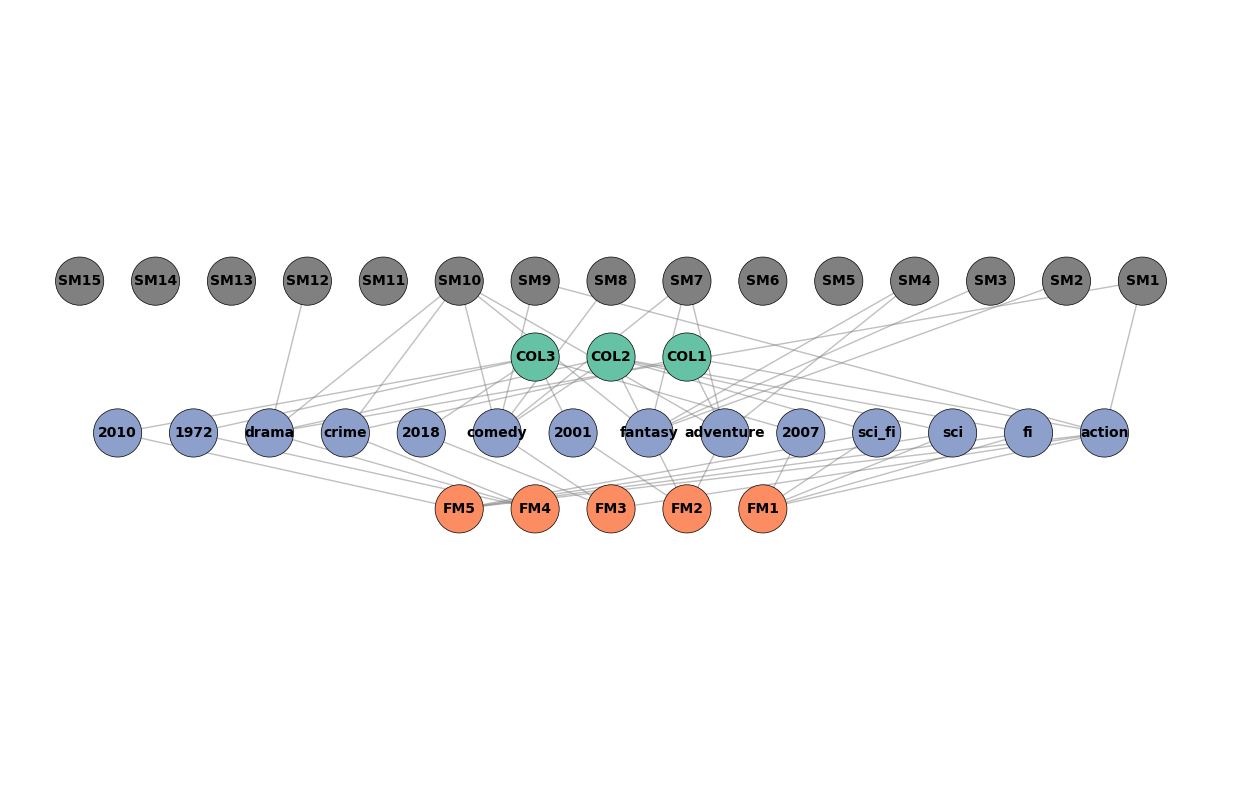

In [ ]:
pos = nx.layout.multipartite_layout(graph, align="horizontal")

visualize_graph(graph=graph, custom_pos=pos)

# Create a dictionary to store ground truth mapping of movie names to processed review IDs

In [46]:
ground_truth = {}

for row in tqdm(movie_reviews.itertuples()):
    if row.movie.lower() not in movie_details:
        continue

    movie_name = row.movie.lower()

    if movie_name not in ground_truth:
        ground_truth[movie_name] = []

    processed_review = remove_stopwords(normalize_text(row.user_review.lower()))
    ground_truth[movie_name].append(id_review[processed_review])


100it [00:00, 1853.03it/s]


# Expansion with DBpedia

In [69]:
from SPARQLWrapper import SPARQLWrapper, JSON

# Set up SPARQLWrapper with DBpedia endpoint
sparql = SPARQLWrapper("http://dbpedia.org/sparql")

# Define SPARQL query to fetch related resources for a given DBpedia entity
query_template = """
    SELECT DISTINCT ?o WHERE {
        <http://dbpedia.org/resource/%s> <http://dbpedia.org/ontology/wikiPageWikiLink> ?o .
    }
"""

def run_dbpedia(entity_name):
    capitalized_name = '_'.join([name_part.capitalize() for name_part in entity_name.split('_')])
    query = query_template % capitalized_name
    
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    
    filtered_results = []
    for result in results["results"]["bindings"]:
        resource_value = result["o"]["value"]
        if not '.jpg' in resource_value and not 'http://dbpedia.org/resource/Category:' in resource_value:
            filtered_results.append(resource_value.split('/')[-1])

    return filtered_results

100%|██████████| 37/37 [00:01<00:00, 21.52it/s]
C:\Users\Saad\AppData\Local\Temp\ipykernel_16364\2917963028.py:46: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for connectionstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(graph, custom_pos, edge_color='gray', alpha=0.5, width=1,


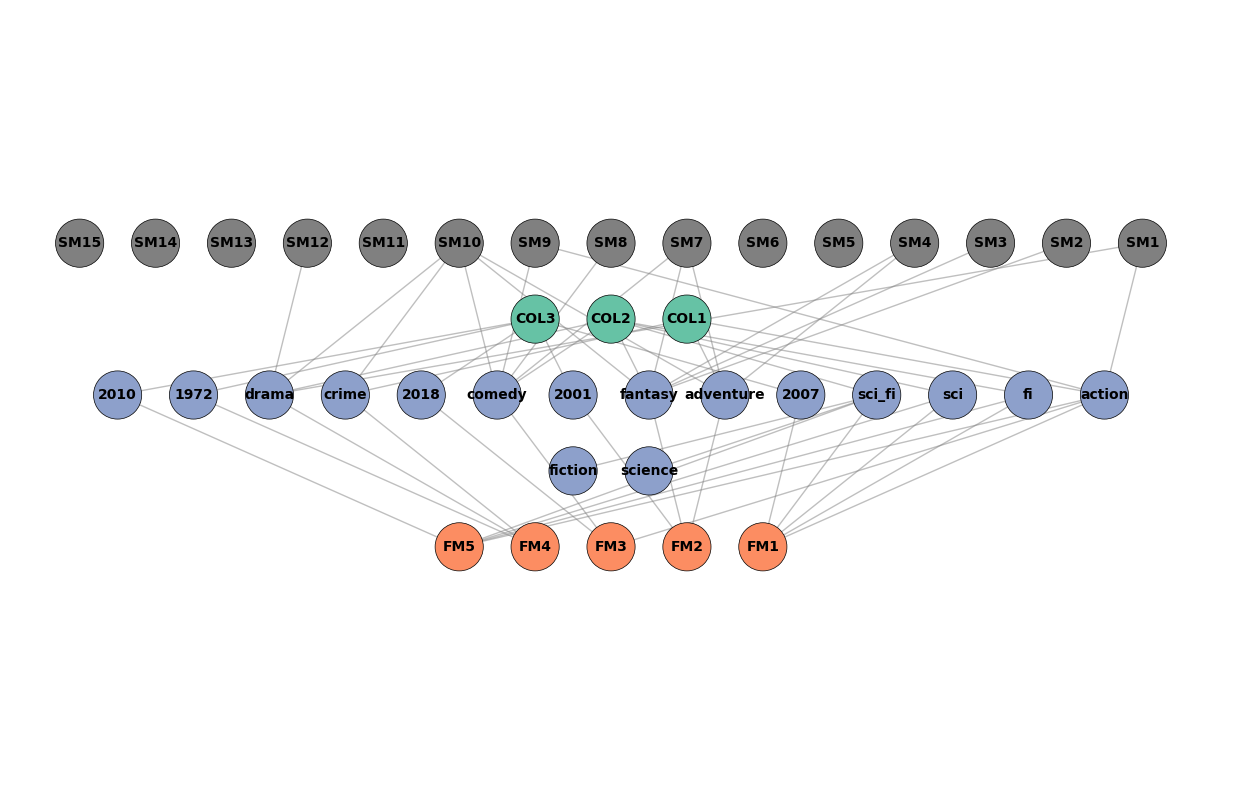

In [70]:
import utils

# Update the graph with nodes and edges based on DBpedia results
for node in tqdm(graph.copy().nodes()):
    if graph.nodes()[node]['type'] != 'Token':
        continue

    token_parts = node.split('_')
    if len(token_parts) < 2 or (len(token_parts) == 2 and token_parts[1].isdigit()):
        continue

    try:
        for related_entity in run_dbpedia(node):
            normalized_entity = utils.normalize_text(related_entity).split('_')
            for sub_entity in normalized_entity:
                if not graph.has_node(sub_entity):
                    graph.add_node(sub_entity, label=sub_entity, type='Token', subset=2)
                    graph.add_edge(node, sub_entity, type='dbp')
    except:
        continue

pos = nx.layout.multipartite_layout(graph, align="horizontal")

visualize_graph(graph=graph, custom_pos=pos)

# Remove nodes with a degree less than 2
for node in graph.copy().nodes():
    if graph.degree()[node] < 1:
        graph.remove_node(node)

In [71]:
#nx.write_graphml(G,'data/imdb/imdb_expanded.gml')

In [72]:
print((len(graph.nodes), len(graph.edges)))

(33, 53)


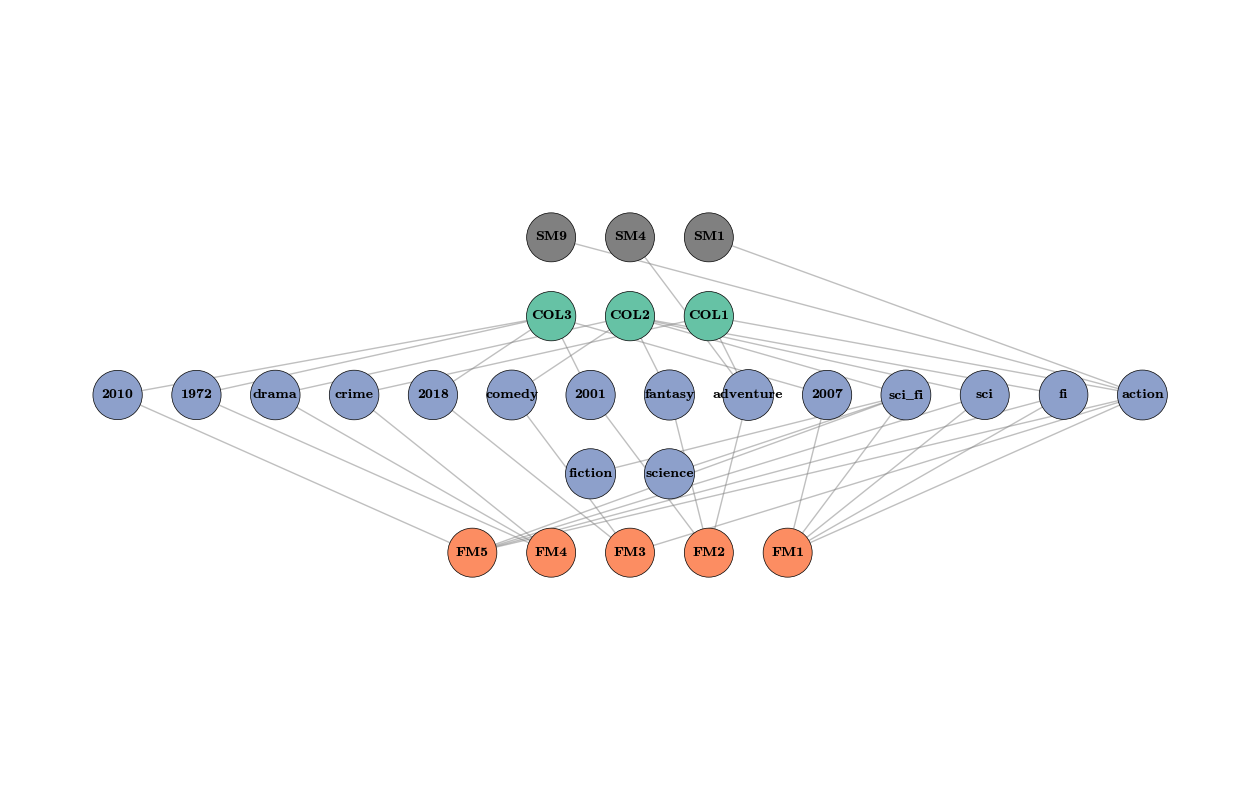

In [285]:
pos = nx.layout.multipartite_layout(graph, align="horizontal")

visualize_graph(graph=graph, custom_pos=pos)

# Compression

## SSuM

In [514]:
# Map node names to numerical IDs and create an inverse mapping
node_counter = 0
node_ids = {}

for node in graph.nodes:
    node_ids[node] = node_counter
    node_counter += 1

inv_nodes = {v: k for k, v in node_ids.items()}

In [515]:
# Write the edge list of the graph to a file with numerical IDs
with open('imdb_edgelist', 'w') as file:
    for edge in graph.edges():
        file.write(str(node_ids[edge[0]]) + '\t' + str(node_ids[edge[1]]) + '\n')   

In [516]:
# Read the summary graph file and remove newline characters
with open('../../SSumM/output/summary_imdb_edgelist.txt') as f:
    summary_graph = [line.strip() for line in f.readlines()]


In [517]:
# Process the summary graph file and extract super_nodes, super_edges, and edge_weights
super_nodes, super_edges = {}, []
edge_weights = {}

for i in range(1, summary_graph.index('<Superedge info>')):
    node = summary_graph[i].split('\t')
    idd = node[0]
    super_nodes[idd] = [inv_nodes[int(n)] for n in node[1:]]

for i in range(summary_graph.index('<Superedge info>') + 1, len(summary_graph)):
    edge = summary_graph[i].split('\t')
    src, dest, weight = edge

    if src not in edge_weights:
        edge_weights[src] = {}
    if dest not in edge_weights:
        edge_weights[dest] = {}

    edge_weights[src][dest] = weight
    edge_weights[dest][src] = weight
    super_edges.append((src, dest))

In [518]:
# Create a new graph (SG) and populate it with super_nodes and super_edges
summary_graph = nx.Graph()

for node in super_nodes:
    if ' '.join(super_nodes[node]).startswith(('RW', 'Review', 'CL')):
        name = ' '.join(super_nodes[node])
    else:
        name = super_nodes[node][0]

    summary_graph.add_node(node, label=name, type='node')

for edge in super_edges:
    summary_graph.add_edge(edge[0], edge[1])

In [519]:
# Replace the original graph (G) with the new summary graph (SG)
graph = summary_graph
print(len(graph.nodes()), len(graph.edges()))

9 6


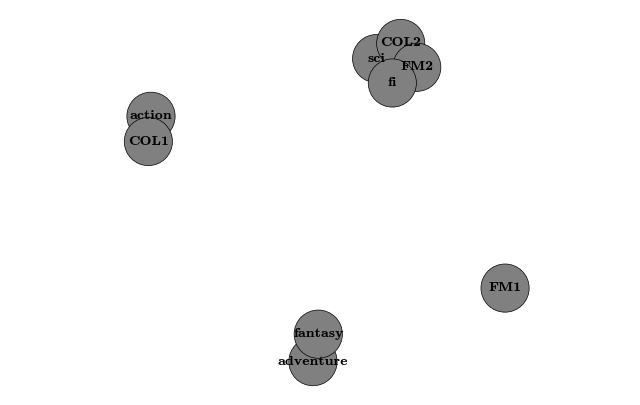

In [520]:
pos = nx.layout.spring_layout(graph)

visualize_graph(graph=graph, custom_pos=pos)

# MSP

In [32]:
from random import choice

# Calculate the target number of iterations (L) as half of the number of nodes in the graph (G)
L = int(len(graph.nodes()) / 2)

# Initialize an empty list (sp), a counter (i), and a progress bar (pbar)
shortest_paths = []
counter = 0
progress_bar = tqdm(total=L, position=0)

# Create a new graph (G1) to store the shortest paths
shortest_paths_graph = nx.Graph()

# Run a loop to add shortest paths between random 'Row' and 'Review' nodes to G1
while counter < L:
    row_node = choice([n for n in graph.nodes() if graph.nodes()[n]['type'] == 'Row'])
    review_node = choice([n for n in graph.nodes() if graph.nodes()[n]['type'] == 'Review'])

    # Calculate all shortest paths between the row_node and review_node
    paths = nx.all_shortest_paths(graph, row_node, review_node, weight=None)

    # Add the nodes and the path to the new graph (shortest_paths_graph)
    for path in paths:
        shortest_paths_graph.add_nodes_from(path)
        nx.add_path(shortest_paths_graph, path)

    # Increment the counter and update the progress bar
    counter += 1
    progress_bar.update(1)


  2%|▏         | 388/16869 [01:53<1:21:57,  3.35it/s]

KeyboardInterrupt: 

In [74]:
# Replace the original graph (G) with the new shortest path graph (SG)
graph = shortest_paths_graph
print(len(graph.nodes()), len(graph.edges()))

24 36


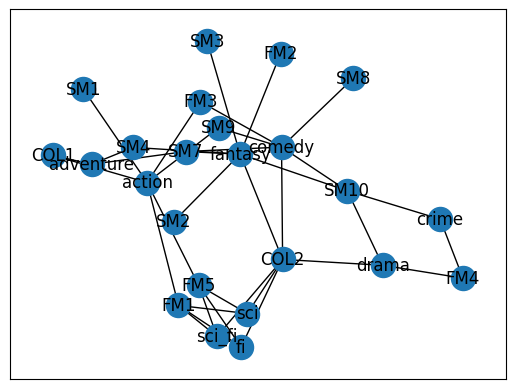

In [75]:
import copy

pos = nx.layout.spring_layout(graph, k = 0.1, seed=42)

viz_graph = copy.deepcopy(graph)

# Remove nodes with a degree less than 1
for node in viz_graph.copy().nodes():
    if viz_graph.degree()[node] < 1:
        viz_graph.remove_node(node)

nx.draw_networkx(graph, pos=pos)

# RandomWalk

In [33]:
# Generate random walks (random_paths) in the graph (G)
random_paths = generate_random_walks(graph, 30, l=30)

# Create an empty list (docs) and append each random walk (p) to the list
documents = []
for path in random_paths:
    documents.append(path)


100%|██████████| 30/30 [33:53<00:00, 67.78s/it]


# Word Embeddings

In [34]:
from gensim.models.word2vec import Word2Vec
from nltk.tokenize import word_tokenize
from gensim.parsing.preprocessing import remove_stopwords
from tqdm import tqdm
import os

# Tokenize each document (d) in the list of documents (docs)
tagged_data = []
for doc in tqdm(documents, position=0):
    tagged_data.append(word_tokenize(doc))

# Set the environment variable 'PYTHONHASHSEED' to 0 for reproducibility
os.environ['PYTHONHASHSEED'] = '0'

# Define the hyperparameters for the Word2Vec model
max_epochs = 10
vec_size = 300

# Create a Word2Vec model with the specified hyperparameters
model = Word2Vec(vector_size=vec_size, min_count=1, window=3, sg=1, seed=0, workers=4)  # Update min_count to 1

# Build the model's vocabulary from the tagged_data
model.build_vocab(tagged_data)

# Train the Word2Vec model using the tagged_data
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Print a message to indicate that the model is ready
print("Model is Ready")

100%|██████████| 1012080/1012080 [03:42<00:00, 4544.91it/s]


Model is Ready


# Test

In [50]:
import random
import utils

# Create an empty dictionary to store movie reviews
movie_reviews = {}

# Iterate through the movies in the ground_truth dictionary using a progress bar
for movie in tqdm(ground_truth):
    # Create an empty list for new reviews
    review_new = []
    
    # Get the movie ID from the id_rows dictionary
    movie_id = id_movies[movie]
    
    # Add the existing reviews in the ground_truth dictionary for the movie to the review_new list
    for review in ground_truth[movie]:
        review_new.append(review)
        
    # Randomly sample 98 reviews not in the ground_truth dictionary for the movie and append them to the review_new list
    for review in random.sample(review_ids.keys(), 10):
        if review not in ground_truth[movie]:
            review_new.append(review)
    
    # Calculate the distance between the movie and the reviews using the Word2Vec model
    movie_reviews[movie] = distance_w2v(model, movie_id, review_ids, 50000)


C:\Users\Saad\AppData\Local\Temp\ipykernel_1952\1658235531.py:19: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  for review in random.sample(review_ids.keys(), 10):
  0%|          | 0/29 [00:00<?, ?it/s]


AttributeError: 'dict' object has no attribute 'wv'

In [79]:
for KK in [1,5,20,50000]: 
    i = 0
    precision,recall,fs = 0,0,0
    MAP, MR, hasP = 0,0,0

    for movie in movie_reviews:
        if movie not in ground_truth: continue
        i+=1
        preds = [f for (f,j) in movie_reviews[movie]][0:KK]
        golds = [f for f in ground_truth[movie]]

        MAP += MAP_K(golds,preds)
        MR += MRR(golds,preds)
        hasP += HAS_POSITIVE(golds,preds)
        
    print('\n#################### ' + str(KK) + ' ###########################\n')
    print('MRR:',MR/i,'MAP:',MAP/i, 'HAS POSITIVE:', hasP/i)


#################### 1 ###########################

MRR: 0.6 MAP: 0.2 HAS POSITIVE: 0.6

#################### 5 ###########################

MRR: 0.65 MAP: 0.31111111111111106 HAS POSITIVE: 0.8

#################### 20 ###########################

MRR: 0.65 MAP: 0.3551587301587301 HAS POSITIVE: 0.8

#################### 50000 ###########################

MRR: 0.65 MAP: 0.3551587301587301 HAS POSITIVE: 0.8
